In [2]:
import pandas as pd

df_embeds = pd.read_parquet('data/username_weighted_embeds.parquet')
df_train_all = pd.read_parquet('data/training-dataset.parquet')

In [8]:
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.model_selection import train_test_split

df_train = pd.merge(df_embeds, df_train_all[['username','label']], how='left', on='username')
df_train = df_train.dropna(subset=['label'])
df_train = df_train.drop(columns=['username'])


labels = ['entertainment', 'food', 'travel', 'health and lifestyle', 'mom and children', 'fashion', 'tech', 'sports', 'art', 'gaming']

label_encoder = LabelEncoder()
label_encoder.fit(labels)

df_train['target'] = label_encoder.transform(df_train['label'])
df_train = df_train.drop(columns=['label'])


X = df_train.drop(columns=['target'])
y = df_train[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = pd.DataFrame(X_train['embeds_wavg'].tolist())
X_test = pd.DataFrame(X_test['embeds_wavg'].tolist())
# encoder = TargetEncoder()
# cat_encoded_train = encoder.fit_transform(X_train["category_enum"].to_numpy().reshape(-1,1), y_train['target'].tolist())
# X_train['category_encoded'] = [row.tolist() for row in cat_encoded_train]
# X_train = X_train[['embeds_wavg','category_encoded']]

# X_train = pd.concat([pd.DataFrame(X_train['category_encoded'].tolist()), pd.DataFrame(X_train['embeds_wavg'].tolist())],axis=1)



# cat_encoded_test = encoder.transform(X_test['category_enum'].to_numpy().reshape(-1,1))
# X_test['category_encoded'] = [row.tolist() for row in cat_encoded_test]
# X_test = pd.concat([pd.DataFrame(X_test['category_encoded'].tolist()), pd.DataFrame(X_test['embeds_wavg'].tolist())],axis=1)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()



In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report



model = XGBClassifier(
    objective='multi:softmax',
    num_class=10,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    n_estimators=500,
    colsample_bytree=0.8,              
    subsample=0.85,
    device='cuda',
    random_state=42,
    eval_metric=['mlogloss', 'merror'],  # Add metrics to track
    early_stopping_rounds=10  # Optional: stop if no improvement
)



model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

y_pred = model.predict(X_test)

[0]	validation_0-mlogloss:2.19322	validation_0-merror:0.26962	validation_1-mlogloss:2.23856	validation_1-merror:0.57482
[1]	validation_0-mlogloss:2.09392	validation_0-merror:0.18568	validation_1-mlogloss:2.18766	validation_1-merror:0.52372
[2]	validation_0-mlogloss:2.00315	validation_0-merror:0.16104	validation_1-mlogloss:2.14093	validation_1-merror:0.49818
[3]	validation_0-mlogloss:1.91800	validation_0-merror:0.12865	validation_1-mlogloss:2.09963	validation_1-merror:0.48175
[4]	validation_0-mlogloss:1.84173	validation_0-merror:0.10630	validation_1-mlogloss:2.05835	validation_1-merror:0.45255
[5]	validation_0-mlogloss:1.76888	validation_0-merror:0.09489	validation_1-mlogloss:2.02320	validation_1-merror:0.46350
[6]	validation_0-mlogloss:1.70065	validation_0-merror:0.08075	validation_1-mlogloss:1.98526	validation_1-merror:0.45438
[7]	validation_0-mlogloss:1.63741	validation_0-merror:0.07619	validation_1-mlogloss:1.95243	validation_1-merror:0.43978
[8]	validation_0-mlogloss:1.57766	valida


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.19      0.25        36
           1       0.50      0.47      0.49        70
           2       0.57      0.62      0.59        65
           3       0.69      0.71      0.70       101
           4       0.00      0.00      0.00         3
           5       0.53      0.67      0.59       102
           6       0.45      0.19      0.27        26
           7       0.84      0.57      0.68        28
           8       0.56      0.68      0.61        63
           9       0.61      0.57      0.59        54

    accuracy                           0.57       548
   macro avg       0.51      0.47      0.48       548
weighted avg       0.57      0.57      0.56       548


Additional Metrics:
Accuracy: 0.5748
Macro F1: 0.4772
Weighted F1: 0.5635
Macro Precision: 0.5097
Macro Recall: 0.4681


/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: 

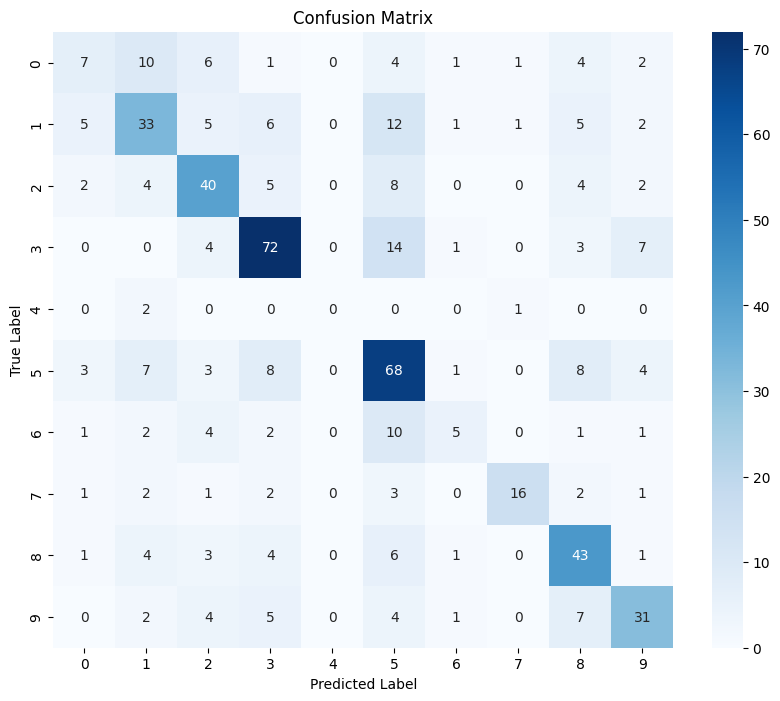

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Print detailed metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [45]:
# Print confusion details
cm = confusion_matrix(y_test, y_pred)
class_confusion = []

for i in range(len(cm)):
    misclassified = sum(cm[i]) - cm[i][i]  # total - correct predictions
    accuracy = cm[i][i] / sum(cm[i])
    class_confusion.append((i, misclassified, accuracy))

# Sort by number of misclassifications
class_confusion.sort(key=lambda x: x[1], reverse=True)

print("\nClass-wise Analysis:")
for class_idx, misclassified, accuracy in class_confusion:
    print(f"Class {class_idx}: Accuracy={accuracy:.2f}, Misclassified={misclassified}")


Class-wise Analysis:
Class 1: Accuracy=0.45, Misclassified=35
Class 5: Accuracy=0.72, Misclassified=28
Class 0: Accuracy=0.29, Misclassified=27
Class 2: Accuracy=0.65, Misclassified=21
Class 6: Accuracy=0.30, Misclassified=21
Class 9: Accuracy=0.68, Misclassified=19
Class 8: Accuracy=0.74, Misclassified=18
Class 3: Accuracy=0.86, Misclassified=14
Class 7: Accuracy=0.48, Misclassified=12
Class 4: Accuracy=0.00, Misclassified=3
